# Active Learning Practical

Active Learning is generally useful in a specific case of small data: when unlabelled data is plentiful, but labelling it is costly. Think for example that each example must be analysed by an expert for labelling it. Expert time is costly, so we would like to be able to train a successful classifier while labelling as few examples as possible.

Active Learning is an approach to answer this problem. The general principle is the following: we first randomly ask the expert to label a small random subset of the training data, and train our classifier on it. Once this first step is done, we can analyse the behaviour of our trained model on the yet unlabelled data, to deduce which additional examples would be worth labelling to improve the quality of the model as quickly as possible. We then retrain the model on the new larger labelled dataset and iterate this process, labelling more and more examples, until we reach a satisfying performance. And hopefully reaching it while only labelling a small fraction of the whole available dataset.

The main question in Active Learning is thus the following: How should we choose the next batch of examples to be labelled?

There are different strategies for this, that you will compare in this practical.

### Example setup

We will emulate an active learning situation using the MNIST dataset, starting by pretending we don't have the labels. The "ask an expert to label the example" step will thus be simply picking the label from the dataset.

You'll have to provide a neural network architecture and the implementation of various active learning strategies, with the goal of comparing them. Keep in mind that the start of the training will be on very small datasets when designing your architectures.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset

import random
import numpy as np


import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Loading MNIST dataset from torchvision.dataset
original_mnist = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)



Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [0]:
# This function creates an unlabelled dataset based on the MNIST images
#
# All examples that are not yet labelled have a label set to -1
def unlabeled_dataset():
    return TensorDataset(
        original_mnist.data[5000:].float() * 2.0 / 255.0 -1.0,
        torch.zeros_like(original_mnist.targets[5000:])-1
    )

# This function labels the requested examples on an unlabelled dataset
def call_expert(dataset, indices):
    for i in indices:
        dataset.tensors[1][i] = original_mnist.targets[5000+i]

# Keep 5000 examples as a validation
mnist_validation = TensorDataset(
    original_mnist.data[:5000].float() * 2.0 / 255.0 -1.0,
    original_mnist.targets[:5000]
)

You can here define your model that will be used for the Active learning process:

***

**We re-use the 2 best models found for the MNIST dataset during TP1 Ex2 and TP1 Ex3**


But adding dropout to make it more stable by reducing overfitting
***

In [0]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = nn.Conv2d(1,20, kernel_size=5, padding=2)
        self.maxpool=nn.MaxPool2d(2)
            
        self.l2 = nn.Conv2d(20,20, kernel_size=3, padding=2)
        
        self.l3 = nn.Conv2d(20,20, kernel_size=3, padding=2)
        
        self.linear = nn.Linear(2000,10)
        
        self.acti=torch.nn.functional.relu
        
    def forward(self, inputs):
        inputs = inputs.unsqueeze(1)
        
        inputs = self.l1(inputs)
        torch.nn.Dropout(0.5) #50% probability

        inputs = self.l2(self.maxpool(inputs))

        torch.nn.Dropout(0.3) #30% probability

        inputs = self.l3(self.maxpool(inputs))
        torch.nn.Dropout(0.2) #20% probability

        inputs = torch.flatten(inputs, 1)
        inputs = self.linear(inputs)
        outputs = self.acti(inputs)# Use softmax as the activation function for the last layer
        
        return outputs

In [0]:
class Model_2(nn.Module):
    
    def __init__(self):
        super(Model_2, self).__init__()
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(2)
        self.kernel1 = 5
        self.kernel2 = 3
        self.kernel3 = 3
        p = 0
        s = 1

        out_size1 = (28 + p + s - self.kernel1) // 2
        out_size2 = (out_size1 + p + s - self.kernel2) // 2
        out_size3 = (out_size2 + p + s - self.kernel3) // 2
        out_channels_n1 = 64
        out_channels_n2 = 128
        out_channels_n3 = 256

        self.conv1_n = nn.Conv2d(1,out_channels_n1, kernel_size=self.kernel1, padding=0, stride=1)
        self.conv2_n = nn.Conv2d(out_channels_n1,out_channels_n2, kernel_size=self.kernel2, padding=0, stride=1)
        self.conv3_n = nn.Conv2d(out_channels_n2,out_channels_n3, kernel_size=self.kernel3, padding=0, stride=1)
        self.l_n = nn.Linear(out_channels_n3*(out_size3**2), 10)
       
    def forward(self, inputs):
        inputs = inputs.unsqueeze(1)

        outputs_n = nn.Tanh()(self.maxpool(self.conv1_n(inputs)))
        torch.nn.Dropout(0.5) #50% probability

        outputs_n = nn.Tanh()(self.maxpool(self.conv2_n(outputs_n)))
        torch.nn.Dropout(0.3) #30% probability

        outputs_n = nn.Tanh()(self.maxpool(self.conv3_n(outputs_n)))
        torch.nn.Dropout(0.2) #20% probability

        outputs_n = torch.flatten(outputs_n, 1)
        outputs_n = self.l_n(outputs_n)
        
        return outputs_n

And here are the learning hyper-parameters, as for the previous practicals you may need to tinker with them:

In [0]:
# number of times the expert will be called to label a batch of examples
num_active_runs = 10

# number of training iterations between each expert call
# the number of epochs is thus num_iter * batch_size / len(dataset)
num_iter = 700
batch_size = 100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.02

Now is the place where you define the strategy to choose the next examples to label. A strategy is a function taking as input your model and the dataset, and returning a list of examples to label.

You can create several functions to test different strategies.

**Random strategy**


In [0]:
def random_strategy(model, dataset):
    # label 100 new examples at random
    N = len(dataset)
    return torch.randint(0, N, (100,))


**Max value-based strategies**

In [0]:
def top_100_uncertain(model, dataset):
    # Returns the top 100 examples for which the classifier is the most uncertain : 
    # we look at the maximum value out of the 10 for each prediction (which are not proba here but the idea is the same)
    # and we keep the predictions with the smallest maximum value 
    use_cuda = torch.cuda.is_available()
    
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    max_vals = []

    # Get prediction for each sample
    with torch.no_grad():
        for (data, targets) in loader:
            if use_cuda :
                data = data.cuda()
                targets = targets.cuda()

            prediction = model(data)
            max_vals.append(torch.max(prediction))
    
    # We set to the highest possible value for the samples for which we already have a label
    # so we do not pick them
    max_vals = np.array(max_vals)
    max_vals[dataset.tensors[1]>-1] = np.inf
    
    # We choose the indices of the 100 samples with lowest max value
    max_vals_idx = np.argsort(max_vals)[:100]
    
    return max_vals_idx



def top_batch_uncertain(model, dataset):
    # Returns the batch of size 100 with the lowest average maximum value of prediction
    use_cuda = torch.cuda.is_available()
    
    loader = DataLoader(dataset, batch_size=100, shuffle=False)
    
    max_vals = []

    # Get prediction for each sample
    with torch.no_grad():
        for (data, targets) in loader:
            if use_cuda :
                data = data.cuda()
                targets = targets.cuda()

            prediction = model(data)
            max_vals.append(torch.mean(torch.max(prediction,axis=1)[0]))

    
    ### ------------------
    # Choosing the indices
    max_vals = np.array(max_vals)
    
    # We choose the indices of the batch with the lowest avg max value
    idx_batch = np.argsort(max_vals)[0]

    # Check if whole batch has been chosen previously and in that case take next one
    if torch.sum(dataset.tensors[1][idx_batch*100:(idx_batch+1)*100]>-1) == 100:
        idx_batch = np.argsort(max_vals)[1]

    max_vals_idx = np.arange(idx_batch*100,(idx_batch+1)*100)
    
    return max_vals_idx



def top_50_50_uncertain(model, dataset):
    # Returns the top 50 examples for which the classifier is the most and the least uncertain: 
    # we look at the maximum value out of the 10 for each prediction (which are not proba here but the idea is the same)
    # and we keep the 50 predictions with the smallest maximum value, and the 50 with the highest
    use_cuda = torch.cuda.is_available()
    
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    max_vals = []

    # Get prediction for each sample
    with torch.no_grad():
        for (data, targets) in loader:
            if use_cuda :
                data = data.cuda()
                targets = targets.cuda()

            prediction = model(data)
            max_vals.append(torch.max(prediction))
    max_vals = np.array(max_vals)

    # We set to the highest possible value for the samples for which we already have a label
    # so we do not pick them
    max_vals[dataset.tensors[1]>-1] = - np.inf
    
    ### -------------------------------------------------------------------------------
    # We choose the indices of the 50 samples with lowest max value and 50 with highest
    max_vals_idx = np.argsort(max_vals)[-50:]

    # We set to the lowest possible value for the samples for which we already have a label
    # so we do not pick them
    max_vals[dataset.tensors[1]>-1] = np.inf
    min_vals_idx = np.argsort(max_vals)[:50]

    return np.concatenate((max_vals_idx,min_vals_idx))

**Entropy-based strategies**

In [0]:
def top_100_max_entropy(model, dataset):
    # returns the top 100 examples for which the classifier is the most uncertain regarding the entropy of its output
    use_cuda = torch.cuda.is_available()
    
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    entropies = []

    # Get prediction for each sample
    with torch.no_grad():
        for (data, targets) in loader:
            if use_cuda :
                data = data.cuda()
                targets = targets.cuda()

            prediction = model(data)
            # Transform the prediction values to proba-like values using a softmax
            prediction = torch.softmax(prediction,dim=1)
            entropies.append(- torch.sum(prediction * torch.log(prediction)))
    
    # We set to 0 for the samples for which we already have a label
    # so we do not pick them
    entropies = np.array(entropies)
    entropies[dataset.tensors[1]>-1] = 0
    
    # We choose the indices of the 100 samples with highest entropy
    max_entropies = np.argsort(entropies)[-100:]
    
    return max_entropies


def top_batch_max_entropy(model, dataset):
    # Returns the batch of size 100 with the highest average entropy
    use_cuda = torch.cuda.is_available()
    
    loader = DataLoader(dataset, batch_size=100, shuffle=False)
    
    entropies = []

    # Get prediction for each sample
    with torch.no_grad():
        for (data, targets) in loader:
            if use_cuda :
                data = data.cuda()
                targets = targets.cuda()
                
            prediction = model(data)
    
            # Transform the prediction values to proba-like values using a softmax
            prediction = torch.softmax(prediction,dim=1)
            entropies.append(- torch.sum(prediction * torch.log(prediction)))
    
    
    ### ------------------
    # Choosing the indices
    entropies = np.array(entropies)
    
    # We choose the indices of the batch with the highest entropy
    idx_batch = np.argsort(entropies)[-1]

    # Check if whole batch has been chosen previously and in that case take next one
    if torch.sum(dataset.tensors[1][idx_batch*100:(idx_batch+1)*100]>-1) == 100:
        idx_batch = np.argsort(entropies)[-2]

    max_entropies = np.arange(idx_batch*100,(idx_batch+1)*100)
    
    return max_entropies

**Difference of top values strategy**

In [0]:
def top_100_difference_uncertain(model, dataset):
    # Returns the top 100 examples for which the classifier is the most uncertain between two values : 
    # we look at the difference between the top 2 scores of prediction
    # and we keep the samples with the smallest difference
    use_cuda = torch.cuda.is_available()
    
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    top_diffs = []

    # Get prediction for each sample
    with torch.no_grad():
        for (data, targets) in loader:
            if use_cuda :
                data = data.cuda()
                targets = targets.cuda()

            prediction = model(data)

            # Getting the top 2 predicted scores
            max_1 = torch.max(prediction)
            prediction[0][torch.argmax(prediction)] = - np.inf
            max_2 = torch.max(prediction)

            top_diffs.append(max_1 - max_2)
    
    # We set to the highest possible value for the samples for which we already have a label
    # so we do not pick them
    top_diffs = np.array(top_diffs)
    top_diffs[dataset.tensors[1]>-1] = np.inf
    
    # We choose the indices of the 100 samples with lowest difference between the top 2 scores
    top_diffs_idx = np.argsort(top_diffs)[:100]
    
    return top_diffs_idx

**Stategy combination**

In [0]:
def top_100_combination_entropy(model, dataset):
    # Returns the top 100 examples for which the classifier is the most uncertain,
    # regarding entropy + difference between top 2 scores
    # -> combination of 2 of the prvious method
    use_cuda = torch.cuda.is_available()
    
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    # Storing both values
    entropies = []
    top_diffs = []

    # Get prediction for each sample
    with torch.no_grad():
        for (data, targets) in loader:
            if use_cuda :
                data = data.cuda()
                targets = targets.cuda()

            prediction = model(data)

            # Getting the entropy
            # Transform the prediction values to proba-like values using a softmax
            pred_proba = torch.softmax(prediction,dim=1)
            entropies.append(- torch.sum(pred_proba * torch.log(pred_proba)))

            # Getting the top 2 predicted scores
            max_1 = torch.max(prediction)
            prediction[0][torch.argmax(prediction)] = - np.inf
            max_2 = torch.max(prediction)

            top_diffs.append(max_1 - max_2)

    top_diffs = np.array(top_diffs).astype(float)
    entropies = np.array(entropies).astype(float)


    ### ---------------------------
    # Combination of the 2 scorings

    # Normalization so they are of comparable scales (and 1-entropy so it is in the same order)
    top_diffs = (top_diffs - np.min(top_diffs))/(np.max(top_diffs) - np.min(top_diffs))
    entropies = 1 - ((entropies - np.min(entropies))/(np.max(entropies) - np.min(entropies)))

     
    # We set to the highest possible value for the samples for which we already have a label
    # so we do not pick them
    top_diffs[dataset.tensors[1]>-1] = 1
    entropies[dataset.tensors[1]>-1] = 1

    combinated_score = top_diffs + entropies

    # We choose the indices of the 100 samples with lowest cobinated score
    top_idx = np.argsort(combinated_score)[:100]

    return top_idx


def top_100_combination_all(model, dataset):
    # Returns the top 100 examples for which the classifier is the most uncertain,
    # regarding entropy + difference between top 2 scores + top score
    # -> combination of all 3 of the previous methods
    use_cuda = torch.cuda.is_available()
    
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    # Storing all 3 values
    entropies = []
    top_diffs = []
    max_vals = []

    # Get prediction for each sample
    with torch.no_grad():
        for (data, targets) in loader:
            if use_cuda :
                data = data.cuda()
                targets = targets.cuda()

            prediction = model(data)

            # Getting the entropy
            # Transform the prediction values to proba-like values using a softmax
            pred_proba = torch.softmax(prediction,dim=1)
            entropies.append(- torch.sum(pred_proba * torch.log(pred_proba)))

            # Getting the top 2 predicted scores
            max_1 = torch.max(prediction)
            prediction[0][torch.argmax(prediction)] = - np.inf
            max_2 = torch.max(prediction)

            max_vals.append(max_1)
            top_diffs.append(max_1 - max_2)

    top_diffs = np.array(top_diffs).astype(float)
    entropies = np.array(entropies).astype(float)
    max_vals = np.array(max_vals).astype(float)


    ### ---------------------------
    # Combination of the 3 scorings

    # Normalization so they are of comparable scales (and 1-entropy so it is in the same order)
    max_vals = (max_vals - np.min(max_vals))/(np.max(max_vals) - np.min(max_vals))
    top_diffs = (top_diffs - np.min(top_diffs))/(np.max(top_diffs) - np.min(top_diffs))
    entropies = 1 - ((entropies - np.min(entropies))/(np.max(entropies) - np.min(entropies)))

     
    # We set to the highest possible value for the samples for which we already have a label
    # so we do not pick them
    max_vals[dataset.tensors[1]>-1] = 1
    top_diffs[dataset.tensors[1]>-1] = 1
    entropies[dataset.tensors[1]>-1] = 1

    combinated_score = top_diffs + entropies + max_vals

    # We choose the indices of the 100 samples with lowest cobinated score
    top_idx = np.argsort(combinated_score)[:100]

    return top_idx

This function is the main training loop, the only part you should need to modify is the initialization of the optimizer (noted by the `# OPTIMIZER` comment).

Don't forget to reload this cell whenever you change the hyper-parameters.

In [0]:
# returns a tensor of values:
# - output[:,0] are the number of labeled examples
# - output[:,1] are the associated accuracies
# - output[:,2] are the associated losses
def active_training(strategy, dataset=None, initial_labeling=20):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        print('Using cuda')

    if dataset is None:
        # Fixing the seed so the starting dataset is the same
        # and the results are comparable
        torch.manual_seed(7777)
        dataset = unlabeled_dataset()
        call_expert(dataset, torch.randint(0, len(dataset), (initial_labeling,)))
    
    def train_model(model, optimizer, loader, epochs):
        for _ in range(epochs):
            for (data, targets) in loader:
                if use_cuda :
                    data = data.cuda()
                    targets = targets.cuda()
                    
                model.zero_grad()
                prediction = model(data)
                loss = criterion(prediction, targets)
                loss.backward()
                optimizer.step()
    
    def validation_perf(model, dataset):
        model.eval()
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        total_accuracy = 0.0
        total_loss = 0.0
        with torch.no_grad():
            for (data, targets) in loader:
                if use_cuda :
                    data = data.cuda()
                    targets = targets.cuda()

                prediction = model(data)
                total_loss += criterion(prediction, targets).item() * data.size(0)
                _, number_predicted = torch.max(prediction.data, 1)
                total_accuracy += (number_predicted == targets).sum()
        return (total_accuracy / len(dataset), total_loss / len(dataset))
    
    performances = torch.zeros(num_active_runs+1, 3)
    
    
    for i in range(num_active_runs+1):
        # filter the dataset to only keep labelled examples
        labelled_idx = dataset.tensors[1] >= 0
        filtered_dataset = TensorDataset(*list(t[labelled_idx] for t in dataset.tensors))
        loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)


        # create a new model to train on this dataset
        model = Model_2()
   
        if use_cuda :
            model.cuda()
        
        # OPTIMIZER
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_iter, eta_min=1e-5)


        train_model(model, optimizer, loader, num_iter // len(loader))
        (valid_acc, valid_loss) = validation_perf(model, mnist_validation)
        
        performances[i, 0] = len(filtered_dataset)
        performances[i, 1] = valid_acc
        performances[i, 2] = valid_loss
        print("With {} examples, valid perf is: {} -- {}%".format(len(filtered_dataset), valid_loss, valid_acc*100))
        
        if i < num_active_runs:
            to_label = strategy(model, dataset)
            call_expert(dataset, to_label)
    
    return performances

The following cells contain code that you can use to compare your different strategies. Fill the `strategies` list with the name of the functions implementing your strategies, and run the cell to compare them.

In [0]:
import time

In [124]:
# a list of strategies you want to compare
strategies = [random_strategy,\
              top_100_uncertain,\
              top_batch_uncertain,
              top_50_50_uncertain,\
              top_100_max_entropy,\
              top_batch_max_entropy,\
              top_100_difference_uncertain,\
              top_100_combination_entropy,\
              top_100_combination_all
             ]
# number of examples to label randomly at the start
initial_labeling = 100

performances = []
for strat in strategies:
    start = time.time()
    print("\nTraining with strategy: {}".format(strat.__name__))
    perf = active_training(strat, initial_labeling=initial_labeling)
    performances.append((strat.__name__, perf))
    print("Computation time:", time.time()-start)
print("done")


Training with strategy: random_strategy
Using cuda
With 100 examples, valid perf is: 0.5332893109321595 -- 83.9800033569336%
With 200 examples, valid perf is: 0.4262974947690964 -- 87.41999816894531%
With 299 examples, valid perf is: 0.335967268794775 -- 89.5%
With 399 examples, valid perf is: 0.3089395041763783 -- 90.87999725341797%
With 499 examples, valid perf is: 0.23945992648601533 -- 92.87999725341797%
With 598 examples, valid perf is: 0.21424681708216667 -- 93.57999420166016%
With 696 examples, valid perf is: 0.20235824078321457 -- 94.19999694824219%
With 794 examples, valid perf is: 0.19533199459314346 -- 94.19999694824219%
With 894 examples, valid perf is: 0.18158764250576495 -- 94.72000122070312%
With 994 examples, valid perf is: 0.16547759603708984 -- 95.47999572753906%
With 1092 examples, valid perf is: 0.15646872624754907 -- 95.41999816894531%
Computation time: 65.4238646030426

Training with strategy: top_100_uncertain
Using cuda
With 100 examples, valid perf is: 0.53328

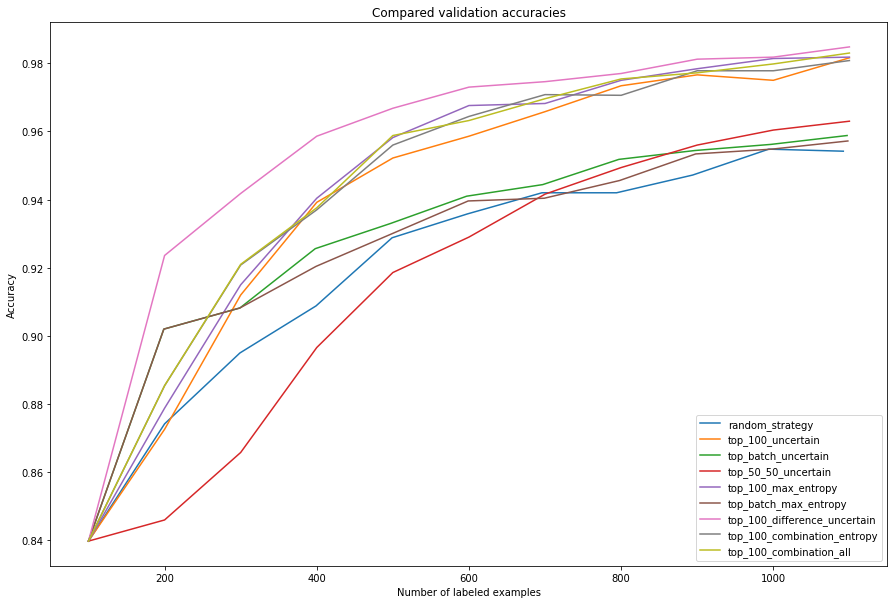

In [125]:
plt.figure(figsize=(15,10))

plt.title("Compared validation accuracies")
plt.xlabel("Number of labeled examples")
plt.ylabel("Accuracy")
for (name, perf) in performances:
    plt.plot(perf[:,0], perf[:,1], label=name)
plt.legend(loc='lower right')
plt.show()

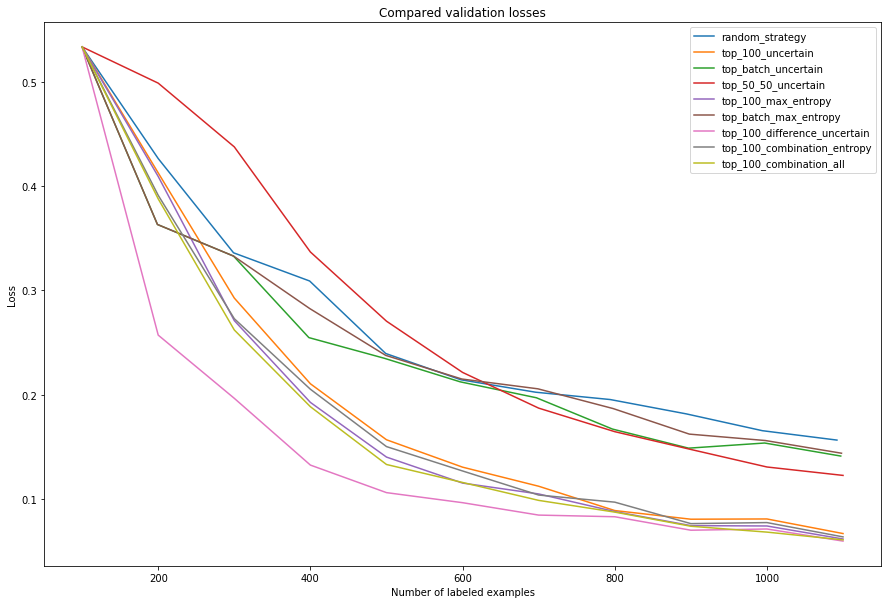

In [126]:
plt.figure(figsize=(15,10))

plt.title("Compared validation losses")
plt.xlabel("Number of labeled examples")
plt.ylabel("Loss")
for (name, perf) in performances:
    plt.plot(perf[:,0], perf[:,2], label=name)
plt.legend(loc='upper right')
plt.show()

***

**The best strategy is the one based on the difference between the Top 2 predicted scores**

The strategy based on the difference of top predicted scores has the best accuracy at all points. Moreover, it improves the fastest relatively to the number of labeled examples, reaching a 96.68% accuray with only 500 examples, and 98.18% with 1000.

The model used was the best one found during the Exercise 3 of TP1 to recognize MNIST number. Here, we added some dropout between the layers to reduce the overfitting which can occur with small datasets.

<br/>

***

**Notes**: 
 - We added a seed for the initialization random labelling so that all methods start with a similarly labeled dataset for fairness.
 - We notice that the "batch" versions of the strategies (looking for a batch of 100 with maximum average uncertainty instead of looking for the samples individually), while still better than Random, are less performing. They are however 10 times faster.


***
<br/>

*Ariane ALIX, Marie HEURTEVENT, Alexandre PACAUD*
<br/>


***

The provided code only implement the "random" strategy, which chooses examples at random to label them. Your task is to compare it to other, more guided strategies. For example:

- a strategy that would label in priority the examples for which the classifier is the most uncertain, as measured by the entropy of its output
- a strategy that would label in priority the examples that appear to be near the frontier between the classes: examples for which the highest and second-highest prediction values of the classifier are close to each other.

You can also try to use other relevant decision criterion for choosing which examples to label, and implement them as new strategies. It is also possible to combine strategies together, in order to combine the strong points of each of them.

**Some advice:**

Keep in mind that your goal is to reach the best possible validation accuracy with as little labelled training examples as possible. As such, don't forget to try and change the number of initial examples for labelling, as well as the number of examples your strategy will request for labelling at each round.

Also keep in mind that you network will be trained on possibly very small datasets (think of only a few hundred of examples), while the validation set contains 5000 examples. Be careful of the risks of over-fitting, adjust your network structure and the training time (`num_iter`) appropriately.

As a baseline, you should be able to reach at least 90% of validation accuracy with less than 500 labelled examples.

**When you are done, you're asked to upload this notebook with your model, the different strategies your compared with the graphs generated by the previous code. Your strategies functions should be commented to explain what each strategy does, and which one is your best strategy.**